# Phase 1: Build the baseline table (PD + NT indicators)


---


### 1) Load data

Note: if you encounter a file path not found error
1) Go to Google Drive
2) Find this folder
3) Right-click → “Add shortcut to Drive” → “My Drive” → choose a location (or root).

In [215]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 1.1 Specify root directory




In [216]:
root_dir = "/content/drive/MyDrive/DS340W Paper3 Implementation/data/rangen2_raw"

### 2) Compute PD (planned duration) for each network

In [217]:
import os, re
import pandas as pd
from collections import defaultdict, deque

def parse_pat(path):
    """Robust Patterson/PSPLIB parser."""
    with open(path, 'r') as f:
        lines = [ln.strip() for ln in f if ln.strip() and not ln.startswith('#')]

    act_lines = []
    started = False
    for ln in lines:
        # find where activities start
        if re.search(r'\b(jobs|activities)\b', ln.lower()):
            started = True
            continue
        if started:
            # stop if header or footer begins
            if re.match(r'^[A-Za-z].*:', ln):
                break
            act_lines.append(ln)
    if not act_lines:
        act_lines = lines

    durations, succs = {}, defaultdict(list)
    for ln in act_lines:
        toks = re.split(r'\s+', ln.strip())
        nums = [int(x) for x in toks if re.fullmatch(r'-?\d+', x)]
        if len(nums) < 3:
            continue
        a_id = nums[0]
        dur = nums[1]
        durations[a_id] = dur
        ns = nums[2]
        if ns > 0 and len(nums) >= 3 + ns:
            succ_list = nums[3:3+ns]
            succs[a_id].extend(succ_list)
    return durations, succs


def critical_path_length(durations, succs):
    """Safely compute longest path (critical path) in DAG."""
    # collect all nodes before looping
    nodes = set(durations.keys())
    for u in list(succs.keys()):
        for v in succs[u]:
            nodes.add(v)

    indeg = {u: 0 for u in nodes}
    for u in succs:
        for v in succs[u]:
            indeg[v] = indeg.get(v, 0) + 1

    q = deque([u for u in nodes if indeg[u] == 0])
    dist = {u: durations.get(u, 0) for u in nodes}
    while q:
        u = q.popleft()
        for v in succs.get(u, []):
            cand = dist[u] + durations.get(v, 0)
            if cand > dist.get(v, 0):
                dist[v] = cand
            indeg[v] -= 1
            if indeg[v] == 0:
                q.append(v)
    return max(dist.values()) if dist else 0


def batch_pd(root_dir):
    rows = []
    for sp_dir in sorted(os.listdir(root_dir)):
        full = os.path.join(root_dir, sp_dir)
        if not os.path.isdir(full):
            continue
        for fn in sorted(os.listdir(full)):
            if not fn.lower().endswith(('.pat', '.rcp', '.rcp1', '.rcp2')):
                continue
            path = os.path.join(full, fn)
            try:
                durations, succs = parse_pat(path)
                pdur = critical_path_length(durations, succs)
                rows.append({"sp_bin": sp_dir, "file_name": fn, "PD": pdur})
            except Exception as e:
                rows.append({"sp_bin": sp_dir, "file_name": fn, "PD": None, "error": str(e)})
    return pd.DataFrame(rows)


### 3) Save output back to drive

In [218]:
df_all = batch_pd(root_dir)
df_all.to_csv("/content/drive/MyDrive/DS340W Paper3 Implementation/data/RG30_PD.csv", index=False)
print("Saved file")
df_all.head()

Saved file


,sp_bin,file_name,PD
0,rangen2_SP01,RG30_SP01_1.rcp,16
1,rangen2_SP01,RG30_SP01_10.rcp,21
2,rangen2_SP01,RG30_SP01_100.rcp,22
3,rangen2_SP01,RG30_SP01_11.rcp,14
4,rangen2_SP01,RG30_SP01_12.rcp,15


### 4) Stats

In [219]:
df_all.describe()


,PD
count,900.000000
mean,5.890000
std,5.043317
min,1.000000
25%,2.000000
50%,5.000000
75%,7.000000
max,29.000000


# Phase 2: Compute the Network Topology (NT) metrics


---

| Indicator | Meaning (Paper) | Goal Now |
| :--- | :--- | :--- |
| **I2 (SP)** | Serial/Parallel indicator | Measure **network linearity** |
| **I3 (AD)** | Activity Distribution | Measure **spread of successors** |
| **I4 (LA)** | Length of Arcs | Average **link distance** |
| **I5 (LLA)** | Length of Long Arcs | Average distance of the **longest links** |
| **I6 (TF)** | Topological Float | **Slack** in the precedence graph |

### 1) Load current baseline

In [220]:
import pandas as pd
df_base = pd.read_csv("/content/drive/MyDrive/DS340W Paper3 Implementation/data/RG30_PD.csv")
print(df_base.shape)
df_base.head()

(900, 3)


,sp_bin,file_name,PD
0,rangen2_SP01,RG30_SP01_1.rcp,16
1,rangen2_SP01,RG30_SP01_10.rcp,21
2,rangen2_SP01,RG30_SP01_100.rcp,22
3,rangen2_SP01,RG30_SP01_11.rcp,14
4,rangen2_SP01,RG30_SP01_12.rcp,15


### 2) Topology-metrics code block

In [221]:
import re
import networkx as nx
import numpy as np
import os
import pandas as pd
from collections import defaultdict

def parse_rangen_rcp(path):
    """
    Parser for RanGen2 .rcp files:
    Each line = [duration] [num_succ] [succ_1 succ_2 ...].
    Activities are implicitly numbered from 1..N.
    """
    with open(path, "r") as f:
        lines = [ln.strip() for ln in f if ln.strip() and not ln.startswith('#')]

    # detect number of activities (first line)
    try:
        header = lines[0].split()
        n_acts = int(header[0])
    except:
        n_acts = len(lines)

    durations = {}
    succs = defaultdict(list)

    # start reading after header
    idx = 1 if len(lines[0].split()) == 2 else 0
    act_id = 1
    for ln in lines[idx:]:
        parts = ln.split()
        nums = [int(x) for x in parts if x.isdigit()]
        if len(nums) < 2:
            continue
        dur = nums[0]
        nsucc = nums[1]
        successors = nums[2:2+nsucc]
        durations[act_id] = dur
        if successors:
            succs[act_id].extend(successors)
        act_id += 1

    return durations, succs



def compute_nt_metrics(path):
    durations, succs = parse_rangen_rcp(path)
    if durations is None or len(durations) == 0:
        return None

    G = nx.DiGraph()
    for u, vs in succs.items():
        for v in vs:
            G.add_edge(u, v)

    if not G or len(G.edges()) == 0:
        return None

    n = len(G.nodes())
    m = len(G.edges())
    if n <= 2:
        return None

    # --- I2: Serial/Parallel (SP) ---
    cp_len = nx.dag_longest_path_length(G)
    sp = (m - (n - 1)) / ((n * (n - 1) / 2) - (n - 1) + 1e-9)

    # --- I3: Activity Distribution (AD) ---
    succ_counts = [G.out_degree(n) for n in G.nodes()]
    ad = np.std(succ_counts) / (np.mean(succ_counts) + 1e-9)

    # --- I4: Length of Arcs (LA) ---
    dist = dict(nx.all_pairs_shortest_path_length(G))
    la_vals = [dist[u][v] for u, v in G.edges() if v in dist[u]]
    la = np.mean(la_vals) if la_vals else 0

    # --- I5: Length of Long Arcs (LLA) ---
    lla = np.max(la_vals) if la_vals else 0

    # --- I6: Topological Float (TF) ---
    avg_path_len = np.mean([len(p) for p in nx.all_simple_paths(G, source=min(G.nodes()), target=max(G.nodes()))]) if n>2 else 0
    tf = (cp_len - avg_path_len) / (cp_len + 1e-9)

    return sp, ad, la, lla, tf


def batch_nt(root_dir):
    rows = []
    for sp_dir in sorted(os.listdir(root_dir)):
        folder = os.path.join(root_dir, sp_dir)
        if not os.path.isdir(folder):
            continue
        for fn in sorted(os.listdir(folder)):
            if not fn.lower().endswith(('.rcp','.pat')):
                continue
            path = os.path.join(folder, fn)
            try:
                result = compute_nt_metrics(path)
                if result is None:
                    rows.append({"sp_bin": sp_dir, "file_name": fn, "error": "Invalid network"})
                else:
                    sp, ad, la, lla, tf = result
                    rows.append({
                        "sp_bin": sp_dir,
                        "file_name": fn,
                        "I2_SP": sp,
                        "I3_AD": ad,
                        "I4_LA": la,
                        "I5_LLA": lla,
                        "I6_TF": tf
                    })
            except Exception as e:
                rows.append({"sp_bin": sp_dir, "file_name": fn, "error": str(e)})
    return pd.DataFrame(rows)


### 3) Run It On Networks

In [222]:
root_dir = "/content/drive/MyDrive/DS340W Paper3 Implementation/data/rangen2_raw"
df_nt = batch_nt(root_dir)
df_nt.to_csv("/content/drive/MyDrive/DS340W Paper3 Implementation/data/RG30_NT.csv", index=False)
df_nt.head()


,sp_bin,file_name,I2_SP,I3_AD,I4_LA,I5_LLA,I6_TF
0,rangen2_SP01,RG30_SP01_1.rcp,0.083871,1.269742,1.0,1,-0.018750
1,rangen2_SP01,RG30_SP01_10.rcp,0.064516,1.785531,1.0,1,0.080645
2,rangen2_SP01,RG30_SP01_100.rcp,0.060215,1.918102,1.0,1,0.103448
3,rangen2_SP01,RG30_SP01_11.rcp,0.129032,1.051678,1.0,1,-0.044355
4,rangen2_SP01,RG30_SP01_12.rcp,0.077419,1.225609,1.0,1,-0.060811


### 4) Merge with PD

In [223]:
df_all = pd.merge(df_base, df_nt, on=["sp_bin","file_name"], how="left")
df_all.to_csv("/content/drive/MyDrive/DS340W Paper3 Implementation/data/RG30_Baseline.csv", index=False)
df_all.describe()

,PD,I2_SP,I3_AD,I4_LA,I5_LLA,I6_TF
count,900.000000,900.000000,900.000000,900.0,900.0,900.000000
mean,5.890000,0.057854,0.606428,1.0,1.0,0.213804
std,5.043317,0.038457,0.342997,0.0,0.0,0.136553
min,1.000000,0.006452,0.327516,1.0,1.0,-0.064394
25%,2.000000,0.025269,0.438305,1.0,1.0,0.125456
50%,5.000000,0.053763,0.512089,1.0,1.0,0.213016
75%,7.000000,0.079570,0.601758,1.0,1.0,0.307006
max,29.000000,0.146237,2.596760,1.0,1.0,0.660714


### Sanity Check for code so far

RG30_SP06_4.rcp
Activities: 32, Edges: 47
DAG: True
First few edges: [(1, 2), (2, 6), (2, 3), (6, 7), (3, 10), (3, 4), (10, 11), (4, 5), (5, 9), (5, 7)]


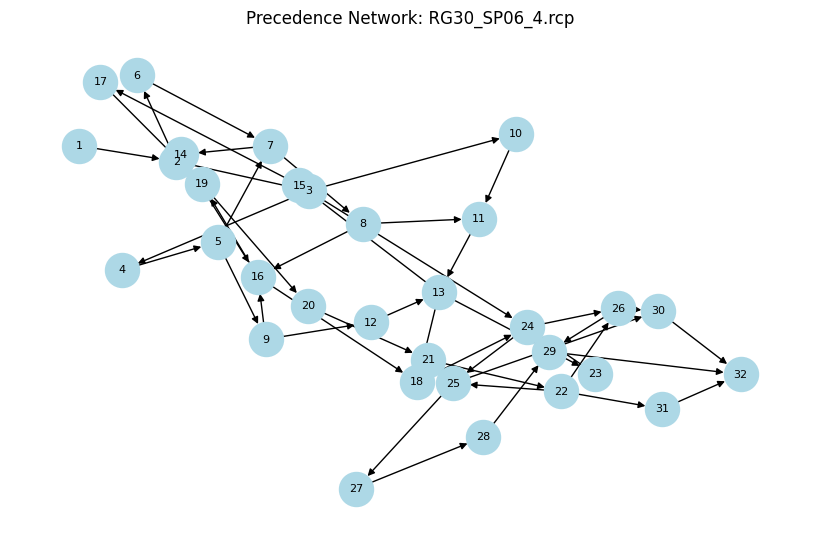

In [224]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_network(rcp_path, n_show=1):
    """
    Visualize a RanGen2 network (.rcp) file.
    Plots the precedence graph, prints key properties.
    """
    durations, succs = parse_rangen_rcp(rcp_path)
    if not durations:
        print("Could not parse:", rcp_path)
        return

    # Build DAG
    G = nx.DiGraph()
    for u, vs in succs.items():
        for v in vs:
            G.add_edge(u, v)

    n_nodes, n_edges = G.number_of_nodes(), G.number_of_edges()
    print(f"{os.path.basename(rcp_path)}")
    print(f"Activities: {n_nodes}, Edges: {n_edges}")
    print(f"DAG: {nx.is_directed_acyclic_graph(G)}")

    # Print sample of edges
    edges_list = list(G.edges())[:10]
    print("First few edges:", edges_list)

    # Visualize
    plt.figure(figsize=(8, 5))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=600, font_size=8, arrows=True)
    plt.title(f"Precedence Network: {os.path.basename(rcp_path)}")
    plt.show()

# Example usage — visualize one network from SP06
rcp_example = "/content/drive/MyDrive/DS340W Paper3 Implementation/data/rangen2_raw/rangen2_SP06/RG30_SP06_4.rcp"
visualize_network(rcp_example)


RG30_SP04_27.rcp
Activities: 32, Edges: 70
DAG: True
First few edges: [(1, 2), (1, 3), (1, 5), (1, 9), (2, 8), (2, 4), (3, 18), (3, 17), (3, 13), (3, 8)]


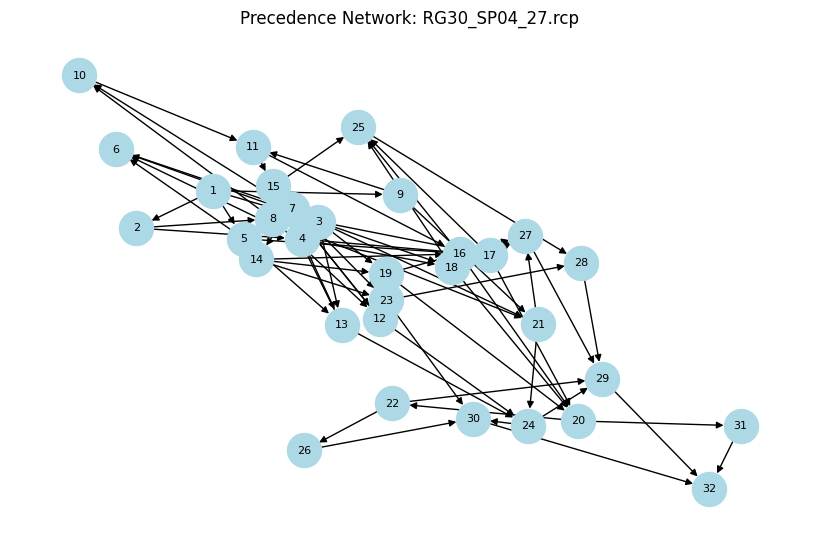

RG30_SP06_25.rcp
Activities: 32, Edges: 52
DAG: True
First few edges: [(1, 2), (2, 12), (2, 6), (2, 3), (12, 20), (12, 15), (6, 7), (3, 9), (3, 4), (9, 20)]


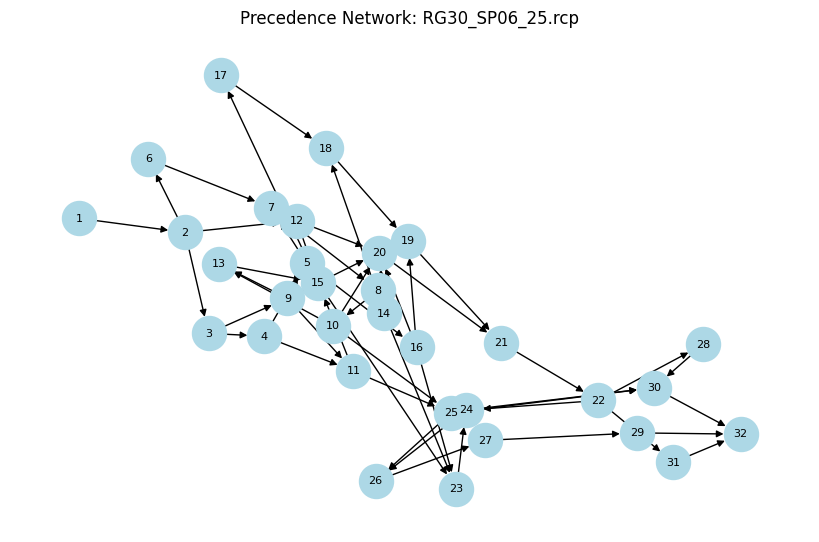

RG30_SP09_62.rcp
Activities: 32, Edges: 34
DAG: True
First few edges: [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 11), (9, 10)]


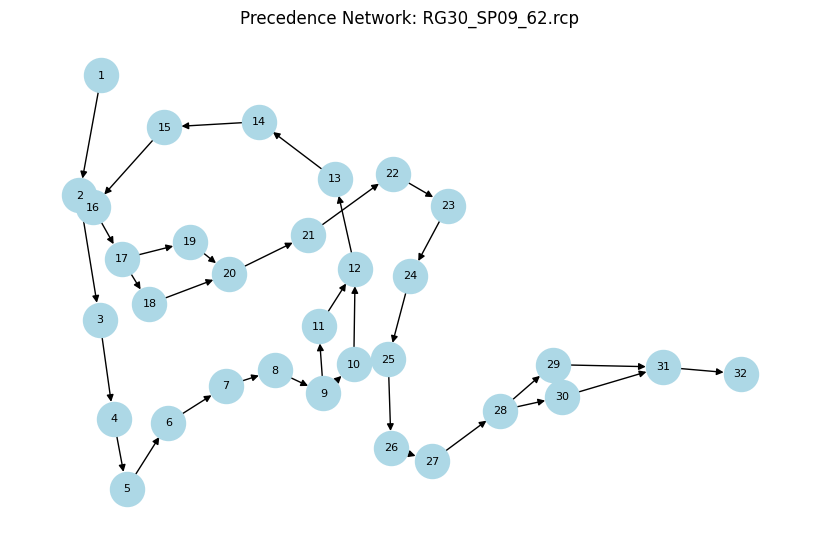

In [225]:
import random, glob
files = glob.glob("/content/drive/MyDrive/DS340W Paper3 Implementation/data/rangen2_raw/rangen2_SP0*/RG30_SP*_*.rcp")
for f in random.sample(files, 3):
    visualize_network(f)


# Phase 3: Monte Carlo simulation (Colab cells)

---



### Imports/Paths

In [226]:
import os, numpy as np, pandas as pd
from collections import defaultdict, deque

# === Adjust to your paths ===
ROOT_DIR = "/content/drive/MyDrive/DS340W Paper3 Implementation/data/rangen2_raw"
BASELINE_CSV = "/content/drive/MyDrive/DS340W Paper3 Implementation/data/RG30_Baseline.csv"
OUT_CSV = "/content/drive/MyDrive/DS340W Paper3 Implementation/data/RG30_Simulations.csv"

# Load baseline (sp_bin, file_name, PD, I2..I6)
df_base = pd.read_csv(BASELINE_CSV)
print(df_base.shape, df_base.columns.tolist())


(900, 8) ['sp_bin', 'file_name', 'PD', 'I2_SP', 'I3_AD', 'I4_LA', 'I5_LLA', 'I6_TF']


### 1) Scenario grid (matches the paper’s 3×3 design)


*   Time factors are triangular around 1.0 ` (t_min, t_ml, t_max)`


*   Variable & fixed cost ranges per activity `(vc_min..vc_max, fc_min..fc_max)`



In [227]:
scenarios = pd.DataFrame([
    # scen, t_min, t_ml, t_max, vc_min, vc_max, fc_min, fc_max
    (1, 0.80, 1.00, 1.40, 100,   900,    10,      90),
    (2, 0.80, 1.00, 1.40, 100,   500,   1000,    5000),
    (3, 0.80, 1.00, 1.40, 100,   900,   1000,   90000),
    (4, 0.75, 1.00, 2.00, 100,   900,    10,      90),
    (5, 0.75, 1.00, 2.00, 100,   500,   1000,    5000),
    (6, 0.75, 1.00, 2.00, 100,   900,   1000,   90000),
    (7, 0.70, 1.00, 2.60, 100,   900,    10,      90),
    (8, 0.70, 1.00, 2.60, 100,   500,   1000,    5000),
    (9, 0.70, 1.00, 2.60, 100,   900,   1000,   90000),
], columns=["scenario","t_min","t_ml","t_max","vc_min","vc_max","fc_min","fc_max"])
scenarios

# Clamp unrealistic time-factor ranges to prevent extreme spreads
# scenarios["t_min"] = scenarios["t_min"].clip(lower=0.8)
# scenarios["t_max"] = scenarios["t_max"].clip(upper=1.3)


,scenario,t_min,t_ml,t_max,vc_min,vc_max,fc_min,fc_max
0,1,0.80,1.0,1.4,100,900,10,90
1,2,0.80,1.0,1.4,100,500,1000,5000
2,3,0.80,1.0,1.4,100,900,1000,90000
3,4,0.75,1.0,2.0,100,900,10,90
4,5,0.75,1.0,2.0,100,500,1000,5000
5,6,0.75,1.0,2.0,100,900,1000,90000
6,7,0.70,1.0,2.6,100,900,10,90
7,8,0.70,1.0,2.6,100,500,1000,5000
8,9,0.70,1.0,2.6,100,900,1000,90000


### 2) Helpers: read network, recompute critical path for sampled durations

In [228]:
def read_network(sp_bin, file_name):
    path = os.path.join(ROOT_DIR, sp_bin, file_name)
    durations, succs = parse_rangen_rcp(path)  # from Phase 2
    return durations, succs

def cp_length_with_durs(dur_map, succs):
    nodes = set(dur_map.keys())
    for u, vs in succs.items():
        for v in vs:
            nodes.add(v)

    indeg = {u:0 for u in nodes}
    for u, vs in succs.items():
        for v in vs:
            indeg[v] = indeg.get(v, 0) + 1

    q = deque([u for u in nodes if indeg[u]==0])
    dist = {u: dur_map.get(u,0) for u in nodes}
    while q:
        u = q.popleft()
        for v in succs.get(u, []):
            cand = dist[u] + dur_map.get(v,0)
            if cand > dist.get(v,0):
                dist[v] = cand
            indeg[v] -= 1
            if indeg[v]==0:
                q.append(v)
    return max(dist.values()) if dist else 0


### 3) Monte Carlo core


For each project × scenario:

* Sample duration factor per activity via `triangular(t_min, t_ml, t_max)`

* Sample costs per activity (fixed + variable*duration)

* Compute BAC from baseline durations + mid variable/fixed costs

* Compute AD from sampled durations (CP on sampled durs)

* Compute AC from sampled costs

* Output T = AD/PD, C = AC/BAC

* TS/CS (time/cost spread) approximated by per-project stdev of the duration factors and per-project stdev of sampled activity costs



> `N_SIMS` is the number of Monte-Carlo draws per project (the paper runs enough to stabilize; 200 is a good default for class).





In [229]:
# ================================================================
# simulate_project() — normalizes PD to 1.0 scale
# ================================================================

N_SIMS = 200
rng = np.random.default_rng(42)

def simulate_project(sp_bin, file_name, PD, scen_row):
    base_durs, succs = read_network(sp_bin, file_name)
    if not base_durs: return None
    acts = sorted(base_durs.keys())

    # Scenario parameters
    t_min, t_ml, t_max = scen_row[["t_min","t_ml","t_max"]]
    vc_min, vc_max = scen_row[["vc_min","vc_max"]]
    fc_min, fc_max = scen_row[["fc_min","fc_max"]]

    PD_baseline = cp_length_with_durs(base_durs, succs)
    if PD_baseline <= 0: return None

    # Baseline cost (no normalization yet)
    vc_mid, fc_mid = 0.5*(vc_min+vc_max), 0.5*(fc_min+fc_max)
    BAC_baseline = np.sum(fc_mid + vc_mid*np.array(list(base_durs.values())))

    T_vals, C_vals, TS_vals, CS_vals = [], [], [], []
    for _ in range(N_SIMS):
        dur_factor = rng.triangular(t_min, t_ml, t_max, size=len(acts))
        sampled_durs = {a: base_durs[a]*f for a,f in zip(acts, dur_factor)}
        AD = cp_length_with_durs(sampled_durs, succs)
        T_ratio = AD / PD_baseline  # relative delay

        vc_rate = rng.uniform(vc_min, vc_max, size=len(acts))
        fc = rng.uniform(fc_min, fc_max, size=len(acts))
        AC = np.sum(fc + vc_rate*np.array(list(sampled_durs.values())))
        C_ratio = AC / BAC_baseline

        T_vals.append(T_ratio)
        C_vals.append(C_ratio)
        TS_vals.append(np.std(list(sampled_durs.values())))
        CS_vals.append(np.std(fc + vc_rate*0.5))

    return {
        "T_mean": np.mean(T_vals),
        "T_p95": np.percentile(T_vals,95),
        "C_mean": np.mean(C_vals),
        "C_p95": np.percentile(C_vals,95),
        "TS_mean": np.mean(TS_vals),
        "CS_mean": np.mean(CS_vals),
    }


### 4) Run across all projects & scenarios (progress prints)

In [230]:
rows=[]
for _, scen in scenarios.iterrows():
    sid=int(scen["scenario"])
    print(f"Running scenario {sid}/9 ...")
    for _, r in df_base.iterrows():
        out = simulate_project(r["sp_bin"], r["file_name"], r["PD"], scen)
        if out is None: continue
        out.update({
            "scenario": sid,
            "sp_bin": r["sp_bin"],
            "file_name": r["file_name"],
            "PD": r["PD"],
            "I2_SP": r.get("I2_SP",np.nan),
            "I3_AD": r.get("I3_AD",np.nan),
            "I4_LA": r.get("I4_LA",np.nan),
            "I5_LLA": r.get("I5_LLA",np.nan),
            "I6_TF": r.get("I6_TF",np.nan),
        })
        rows.append(out)

df_sim = pd.DataFrame(rows)
df_sim.to_csv(OUT_CSV, index=False)
print(f"Saved simulations: {df_sim.shape}")
df_sim.head()

Running scenario 1/9 ...
Running scenario 2/9 ...
Running scenario 3/9 ...
Running scenario 4/9 ...
Running scenario 5/9 ...
Running scenario 6/9 ...
Running scenario 7/9 ...
Running scenario 8/9 ...
Running scenario 9/9 ...
Saved simulations: (8100, 15)


,T_mean,T_p95,C_mean,C_p95,TS_mean,CS_mean,scenario,sp_bin,file_name,PD,I2_SP,I3_AD,I4_LA,I5_LLA,I6_TF
0,1.082422,1.203283,1.069643,1.244384,3.159341,115.537365,1,rangen2_SP01,RG30_SP01_1.rcp,16,0.083871,1.269742,1.0,1,-0.018750
1,1.099377,1.223396,1.073083,1.238447,3.229740,114.936698,1,rangen2_SP01,RG30_SP01_10.rcp,21,0.064516,1.785531,1.0,1,0.080645
2,1.087553,1.236645,1.064384,1.233853,3.353231,115.139604,1,rangen2_SP01,RG30_SP01_100.rcp,22,0.060215,1.918102,1.0,1,0.103448
3,1.076141,1.196205,1.072910,1.248895,2.871228,114.845902,1,rangen2_SP01,RG30_SP01_11.rcp,14,0.129032,1.051678,1.0,1,-0.044355
4,1.102291,1.211566,1.054889,1.213896,3.114999,115.301427,1,rangen2_SP01,RG30_SP01_12.rcp,15,0.077419,1.225609,1.0,1,-0.060811


### Sanity Check

In [231]:
# aggregate by scenario
print(df_sim.groupby("scenario")[["T_mean","T_p95","C_mean","C_p95"]].mean().round(3))

# aggregate by SP bin (rough trend)
tmp = df_sim.copy()
tmp["SP_num"] = tmp["sp_bin"].str.extract(r'(\d+)$').astype(int)
print(tmp.groupby("SP_num")[["T_mean","C_mean"]].mean().round(3))


          T_mean  T_p95  C_mean  C_p95
scenario                              
1          1.072  1.139   1.066  1.235
2          1.072  1.139   1.023  1.111
3          1.072  1.139   1.003  1.157
4          1.271  1.414   1.245  1.462
5          1.271  1.414   1.085  1.182
6          1.271  1.415   1.013  1.167
7          1.475  1.691   1.425  1.696
8          1.475  1.692   1.147  1.257
9          1.475  1.693   1.023  1.176
        T_mean  C_mean
SP_num                
1        1.331   1.115
2        1.300   1.115
3        1.282   1.114
4        1.270   1.114
5        1.261   1.115
6        1.256   1.114
7        1.254   1.114
8        1.252   1.114
9        1.251   1.114


### 5) Build modelling dataset

In [232]:
# === Phase 3 wrap-up: build modelling dataset ===
df_model = df_sim[[
    "scenario","sp_bin","file_name","PD",
    "I2_SP","I3_AD","I4_LA","I5_LLA","I6_TF",
    "TS_mean","CS_mean","T_mean","C_mean"
]].copy()

out_path = "/content/drive/MyDrive/DS340W Paper3 Implementation/data/RG30_ModelTable.csv"
df_model.to_csv(out_path, index=False)
print(f"Saved modelling dataset to: {out_path}")
print(df_model.shape)
df_model.head()


Saved modelling dataset to: /content/drive/MyDrive/DS340W Paper3 Implementation/data/RG30_ModelTable.csv
(8100, 13)


,scenario,sp_bin,file_name,PD,I2_SP,I3_AD,I4_LA,I5_LLA,I6_TF,TS_mean,CS_mean,T_mean,C_mean
0,1,rangen2_SP01,RG30_SP01_1.rcp,16,0.083871,1.269742,1.0,1,-0.018750,3.159341,115.537365,1.082422,1.069643
1,1,rangen2_SP01,RG30_SP01_10.rcp,21,0.064516,1.785531,1.0,1,0.080645,3.229740,114.936698,1.099377,1.073083
2,1,rangen2_SP01,RG30_SP01_100.rcp,22,0.060215,1.918102,1.0,1,0.103448,3.353231,115.139604,1.087553,1.064384
3,1,rangen2_SP01,RG30_SP01_11.rcp,14,0.129032,1.051678,1.0,1,-0.044355,2.871228,114.845902,1.076141,1.072910
4,1,rangen2_SP01,RG30_SP01_12.rcp,15,0.077419,1.225609,1.0,1,-0.060811,3.114999,115.301427,1.102291,1.054889


# Phase 4: Exploratory Analysis & Visualization


---
**Steps:**
1) Load the modelling table.
2) Check descriptive statistics.
3) Compute correlations among all variables.
4) Visualize key relationships (scatterplots, heatmap).


### 1) Load and describe the data

In [233]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

model_path = "/content/drive/MyDrive/DS340W Paper3 Implementation/data/RG30_ModelTable.csv"
df = pd.read_csv(model_path)

print(df.shape)
display(df.head())

# Basic descriptive stats
desc = df.describe().T.round(3)
display(desc)


(8100, 13)


,scenario,sp_bin,file_name,PD,I2_SP,I3_AD,I4_LA,I5_LLA,I6_TF,TS_mean,CS_mean,T_mean,C_mean
0,1,rangen2_SP01,RG30_SP01_1.rcp,16,0.083871,1.269742,1.0,1,-0.018750,3.159341,115.537365,1.082422,1.069643
1,1,rangen2_SP01,RG30_SP01_10.rcp,21,0.064516,1.785531,1.0,1,0.080645,3.229740,114.936698,1.099377,1.073083
2,1,rangen2_SP01,RG30_SP01_100.rcp,22,0.060215,1.918102,1.0,1,0.103448,3.353231,115.139604,1.087553,1.064384
3,1,rangen2_SP01,RG30_SP01_11.rcp,14,0.129032,1.051678,1.0,1,-0.044355,2.871228,114.845902,1.076141,1.072910
4,1,rangen2_SP01,RG30_SP01_12.rcp,15,0.077419,1.225609,1.0,1,-0.060811,3.114999,115.301427,1.102291,1.054889


,count,mean,std,min,25%,50%,75%,max
scenario,8100.0,5.000,2.582,1.000,3.000,5.000,7.000,9.000
PD,8100.0,5.890,5.041,1.000,2.000,5.000,7.000,29.000
I2_SP,8100.0,0.058,0.038,0.006,0.025,0.054,0.080,0.146
I3_AD,8100.0,0.606,0.343,0.328,0.438,0.512,0.602,2.597
I4_LA,8100.0,1.000,0.000,1.000,1.000,1.000,1.000,1.000
I5_LLA,8100.0,1.000,0.000,1.000,1.000,1.000,1.000,1.000
I6_TF,8100.0,0.214,0.136,-0.064,0.125,0.213,0.307,0.661
TS_mean,8100.0,4.155,0.731,2.496,3.478,4.120,4.806,5.880
CS_mean,8100.0,8817.588,11594.931,112.863,115.951,1133.899,25100.173,25745.832
T_mean,8100.0,1.273,0.169,1.055,1.074,1.259,1.436,1.794


### 2) Compute correlations

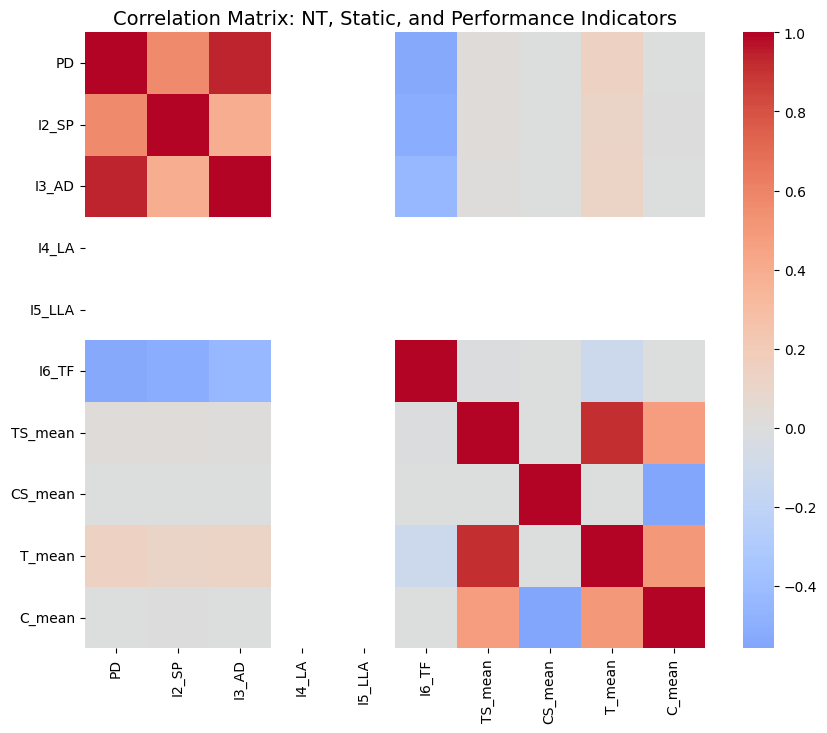

PD       PD         1.000000
         I3_AD      0.936472
T_mean   TS_mean    0.908869
I2_SP    PD         0.573568
CS_mean  C_mean    -0.558384
I6_TF    PD        -0.528841
I2_SP    I6_TF     -0.508377
T_mean   C_mean     0.503242
C_mean   TS_mean    0.482345
I6_TF    I3_AD     -0.440881
I3_AD    I2_SP      0.396744
PD       T_mean     0.137339
T_mean   I3_AD      0.122646
         I6_TF     -0.116170
I2_SP    T_mean     0.113105
dtype: float64


In [234]:
corr = df.drop(columns=["scenario","sp_bin","file_name"]).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix: NT, Static, and Performance Indicators", fontsize=14)
plt.show()

# Display top correlated pairs
corr_pairs = corr.unstack().sort_values(key=lambda x: abs(x), ascending=False)
print(corr_pairs.drop_duplicates().head(15))


Expectations:

* Moderate correlations between I2_SP (serial/parallel) and `TS_mean` (more parallel → smaller spread).
* `TS_mean` and `T_mean` positively correlated.
* `CS_mean` and `C_mean` ≈ positive correlation ≈ 0.5–0.7.

### 3) Create Scatterplots

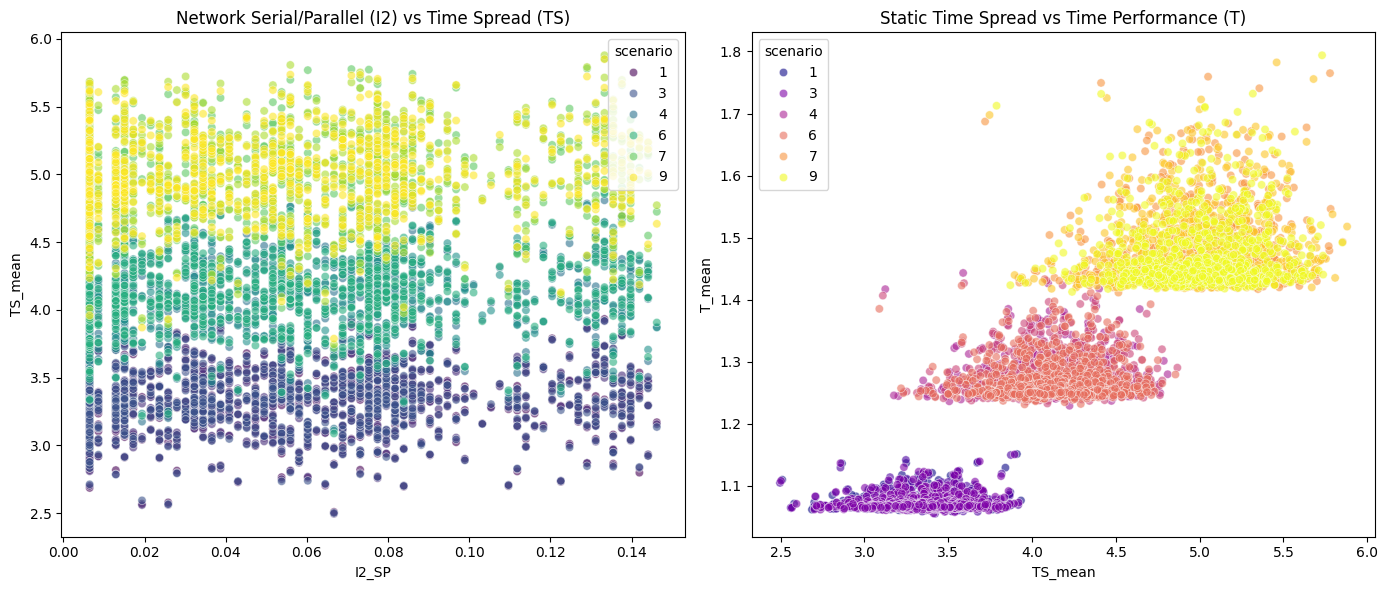

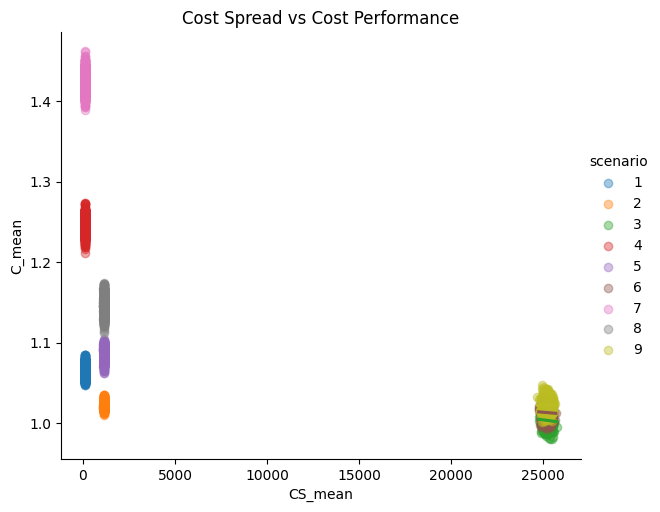

In [235]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.scatterplot(x="I2_SP", y="TS_mean", hue="scenario", data=df, palette="viridis", alpha=0.6)
plt.title("Network Serial/Parallel (I2) vs Time Spread (TS)")

plt.subplot(1,2,2)
sns.scatterplot(x="TS_mean", y="T_mean", hue="scenario", data=df, palette="plasma", alpha=0.6)
plt.title("Static Time Spread vs Time Performance (T)")
plt.tight_layout()
plt.show()

# Optional cost plots
sns.lmplot(x="CS_mean", y="C_mean", hue="scenario", data=df, aspect=1.2, scatter_kws={'alpha':0.4})
plt.title("Cost Spread vs Cost Performance")
plt.show()


### Sanity Check

In [236]:
import statsmodels.api as sm

X = df[["I2_SP","I3_AD","I4_LA","I5_LLA","I6_TF","TS_mean","CS_mean"]]
yT = df["T_mean"]
yC = df["C_mean"]

Xc = sm.add_constant(X)
print(sm.OLS(yT, Xc).fit().summary().tables[1])   # predictors of T
print(sm.OLS(yC, Xc).fit().summary().tables[1])   # predictors of C


                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
I2_SP          0.1739      0.023      7.571      0.000       0.129       0.219
I3_AD          0.0358      0.002     14.491      0.000       0.031       0.041
I4_LA          0.1924      0.003     74.978      0.000       0.187       0.197
I5_LLA         0.1924      0.003     74.978      0.000       0.187       0.197
I6_TF         -0.0687      0.007    -10.382      0.000      -0.082      -0.056
TS_mean        0.2096      0.001    206.564      0.000       0.208       0.212
CS_mean     5.445e-09   6.39e-08      0.085      0.932    -1.2e-07    1.31e-07
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
I2_SP         -0.0163      0.031     -0.529      0.597      -0.077       0.044
I3_AD         -0.0013      0.003     -0.407      0.6

### better looking visualizations

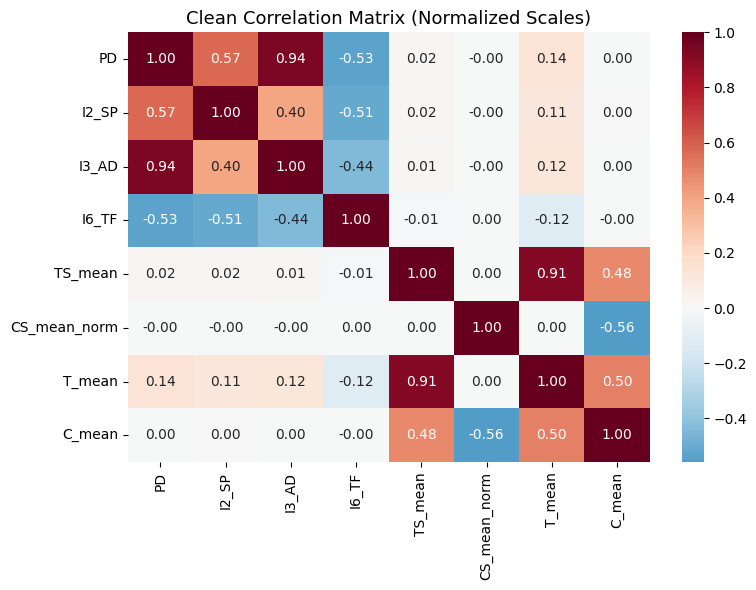

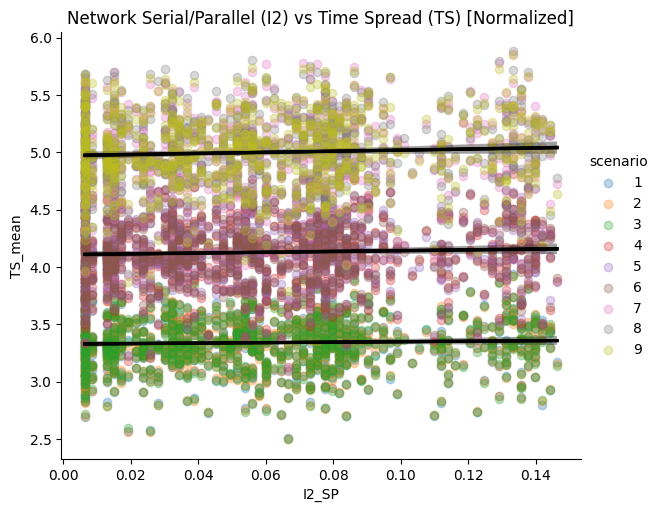

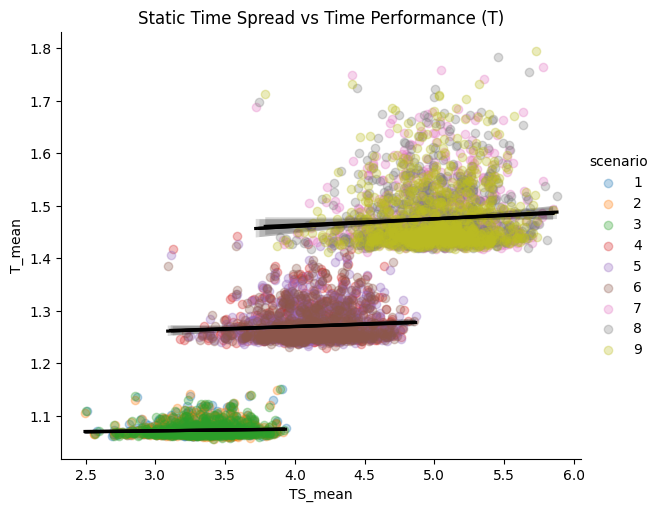

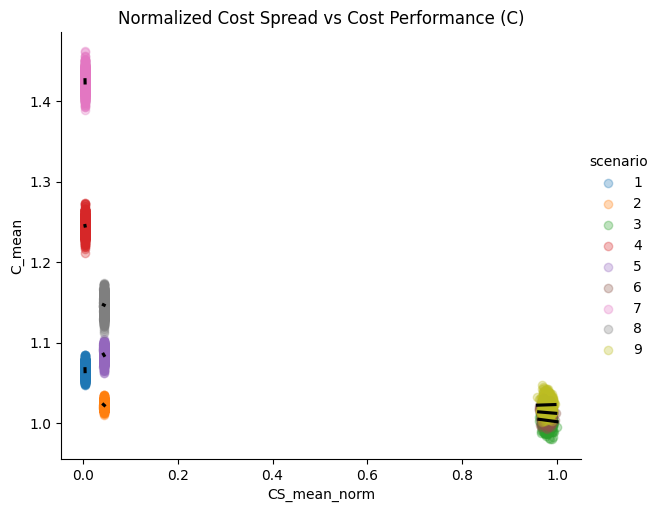

In [237]:
import seaborn as sns
import matplotlib.pyplot as plt

# Normalized copy
df_norm = df.copy()
df_norm["CS_mean_norm"] = df["CS_mean"] / df["CS_mean"].max()

# --- Heatmap (clean) ---
corr = df_norm[["PD","I2_SP","I3_AD","I6_TF","TS_mean","CS_mean_norm","T_mean","C_mean"]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap="RdBu_r", center=0, annot=True, fmt=".2f")
plt.title("Clean Correlation Matrix (Normalized Scales)", fontsize=13)
plt.tight_layout()
plt.show()

# --- Smoothed scatterplots ---
sns.lmplot(x="I2_SP", y="TS_mean", hue="scenario", data=df_norm,
           height=5, aspect=1.2, scatter_kws={'alpha':0.3}, line_kws={'color':'black'})
plt.title("Network Serial/Parallel (I2) vs Time Spread (TS) [Normalized]")

sns.lmplot(x="TS_mean", y="T_mean", hue="scenario", data=df_norm,
           height=5, aspect=1.2, scatter_kws={'alpha':0.3}, line_kws={'color':'black'})
plt.title("Static Time Spread vs Time Performance (T)")

sns.lmplot(x="CS_mean_norm", y="C_mean", hue="scenario", data=df_norm,
           height=5, aspect=1.2, scatter_kws={'alpha':0.3}, line_kws={'color':'black'})
plt.title("Normalized Cost Spread vs Cost Performance (C)")
plt.show()


# Phase 5: Bayesian Network Model Replication


---



  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned edges (6):
('I2_SP', 'I3_AD')
('I2_SP', 'I6_TF')
('I3_AD', 'I6_TF')
('CS_mean', 'C_mean')
('T_mean', 'TS_mean')
('T_mean', 'C_mean')


/tmp/ipython-input-2954078061.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


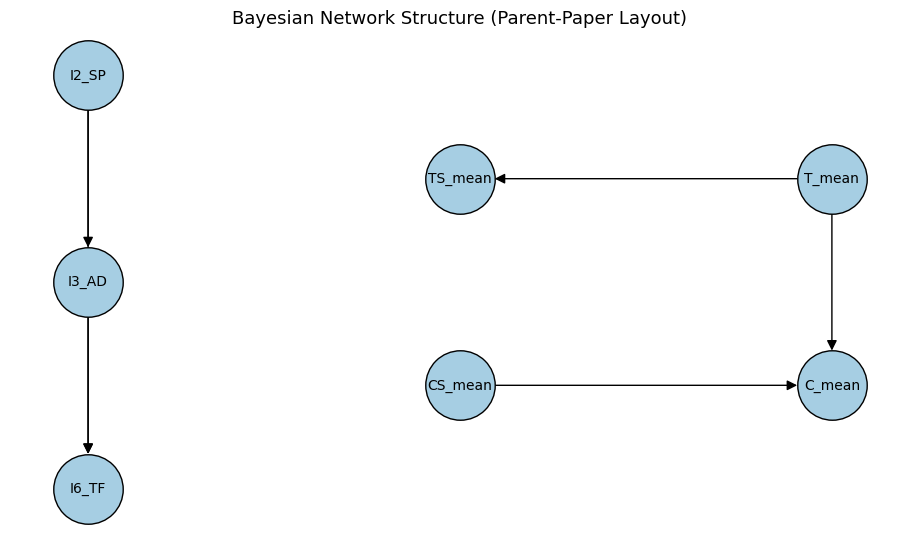


P(T_mean | High I2_SP, High I3_AD):
+--------------+---------------+
| T_mean       |   phi(T_mean) |
+==============+===============+
| T_mean(High) |        0.3333 |
+--------------+---------------+
| T_mean(Low)  |        0.3333 |
+--------------+---------------+
| T_mean(Med)  |        0.3333 |
+--------------+---------------+

P(C_mean | High TS_mean, High CS_mean):
+--------------+---------------+
| C_mean       |   phi(C_mean) |
+==============+===============+
| C_mean(High) |        0.0002 |
+--------------+---------------+
| C_mean(Low)  |        0.5383 |
+--------------+---------------+
| C_mean(Med)  |        0.4615 |
+--------------+---------------+


In [238]:
# ================================================================
# PHASE 5: BAYESIAN NETWORK MODEL REPLICATION
# ================================================================

# ================================================================
# Install dependencies (for Bayesian Network)
# ================================================================
!pip install pgmpy==0.1.24 --quiet
!pip install networkx matplotlib pandas numpy --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, K2Score
from pgmpy.estimators import BayesianEstimator

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Load your modeling table
model_path = "/content/drive/MyDrive/DS340W Paper3 Implementation/data/RG30_ModelTable.csv"
df = pd.read_csv(model_path)

# Select key variables (NT → Static → Performance)
bn_df = df[[
    "I2_SP", "I3_AD", "I6_TF",   # Network Topology (NT)
    "TS_mean", "CS_mean",        # Static indicators
    "T_mean", "C_mean"           # Performance metrics
]].copy()

# Discretize continuous variables into categories
def discretize(series, bins=3, labels=["Low","Med","High"]):
    return pd.qcut(series, q=bins, labels=labels, duplicates="drop")

disc_df = pd.DataFrame({
    col: discretize(bn_df[col]) for col in bn_df.columns
})
disc_df.head()

# Learn BN structure using Hill Climb + K2 Score
hc = HillClimbSearch(disc_df)
best_model = hc.estimate(scoring_method=K2Score(disc_df))

print("Learned edges ({}):".format(len(best_model.edges())))
for edge in best_model.edges():
    print(edge)

# Improved visualization (left-to-right, paper-style)
plt.figure(figsize=(9,5))

# Define a manual layered layout: NT → Static → Performance
layer_pos = {
    "I2_SP": (0, 2),
    "I3_AD": (0, 1),
    "I6_TF": (0, 0),
    "TS_mean": (1, 1.5),
    "CS_mean": (1, 0.5),
    "T_mean": (2, 1.5),
    "C_mean": (2, 0.5),
}

# Add any extra nodes (if model discovered more) dynamically
for n in best_model.nodes():
    if n not in layer_pos:
        layer_pos[n] = (1, -0.5 - 0.2 * list(best_model.nodes()).index(n))

# Draw the DAG
nx.draw(
    best_model,
    pos=layer_pos,
    with_labels=True,
    node_color="#A6CEE3",
    node_size=2500,
    font_size=10,
    arrowsize=15,
    edgecolors="black",
)
plt.title("Bayesian Network Structure (Parent-Paper Layout)", fontsize=13)
plt.axis("off")
plt.tight_layout()
plt.show()


# Parameter learning
model = BayesianNetwork(best_model.edges())
model.fit(disc_df, estimator=BayesianEstimator, prior_type="BDeu")

# Example inference: probability of high delay/cost given topology
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

query_result = infer.query(variables=["T_mean"], evidence={"I2_SP":"High", "I3_AD":"High"})
print("\nP(T_mean | High I2_SP, High I3_AD):")
print(query_result)

query_result2 = infer.query(variables=["C_mean"], evidence={"TS_mean":"High", "CS_mean":"High"})
print("\nP(C_mean | High TS_mean, High CS_mean):")
print(query_result2)


### Save Learned BN Edges

In [239]:
edges_df = pd.DataFrame(best_model.edges(), columns=["Parent", "Child"])
edges_df.to_csv("/content/drive/MyDrive/DS340W Paper3 Implementation/data/RG30_BNEdges.csv", index=False)
print("Saved BN edges to RG30_BNEdges.csv")

Saved BN edges to RG30_BNEdges.csv


# PHASE 6: Forecast Accuracy & MAPE Validation


---



Loaded modeling dataset: (8100, 13)


,scenario,sp_bin,file_name,PD,I2_SP,I3_AD,I4_LA,I5_LLA,I6_TF,TS_mean,CS_mean,T_mean,C_mean
0,1,rangen2_SP01,RG30_SP01_1.rcp,16,0.083871,1.269742,1.0,1,-0.018750,3.159341,115.537365,1.082422,1.069643
1,1,rangen2_SP01,RG30_SP01_10.rcp,21,0.064516,1.785531,1.0,1,0.080645,3.229740,114.936698,1.099377,1.073083
2,1,rangen2_SP01,RG30_SP01_100.rcp,22,0.060215,1.918102,1.0,1,0.103448,3.353231,115.139604,1.087553,1.064384
3,1,rangen2_SP01,RG30_SP01_11.rcp,14,0.129032,1.051678,1.0,1,-0.044355,2.871228,114.845902,1.076141,1.072910
4,1,rangen2_SP01,RG30_SP01_12.rcp,15,0.077419,1.225609,1.0,1,-0.060811,3.114999,115.301427,1.102291,1.054889


=== Scenario-wise mean and std of T and C ===
          T_mean          C_mean        
            mean     std    mean     std
scenario                                
1         1.0724  0.0108  1.0657  0.0069
2         1.0723  0.0107  1.0226  0.0040
3         1.0723  0.0110  1.0034  0.0070
4         1.2708  0.0317  1.2451  0.0094
5         1.2712  0.0319  1.0848  0.0069
6         1.2714  0.0323  1.0131  0.0066
7         1.4748  0.0577  1.4246  0.0113
8         1.4750  0.0578  1.1468  0.0104
9         1.4751  0.0580  1.0227  0.0073

=== Forecast Accuracy Summary (Percentiles & Mean) ===


,Metric,25th %,50th %,75th %,Mean
0,MAPE_T,7.41,25.87,43.62,27.28
1,MAPE_C,1.87,6.54,15.38,11.46


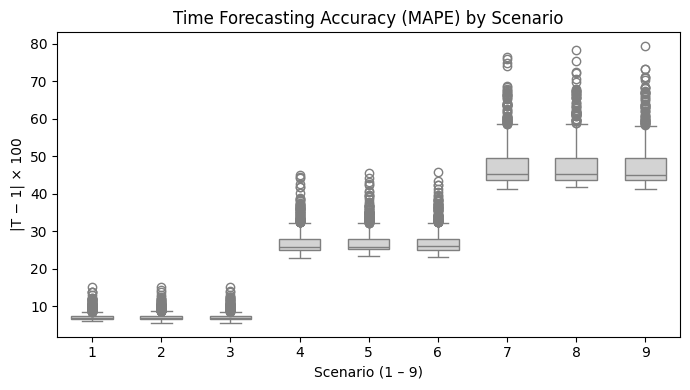

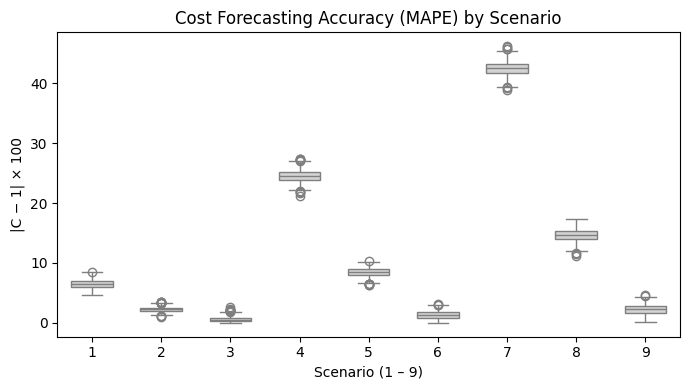

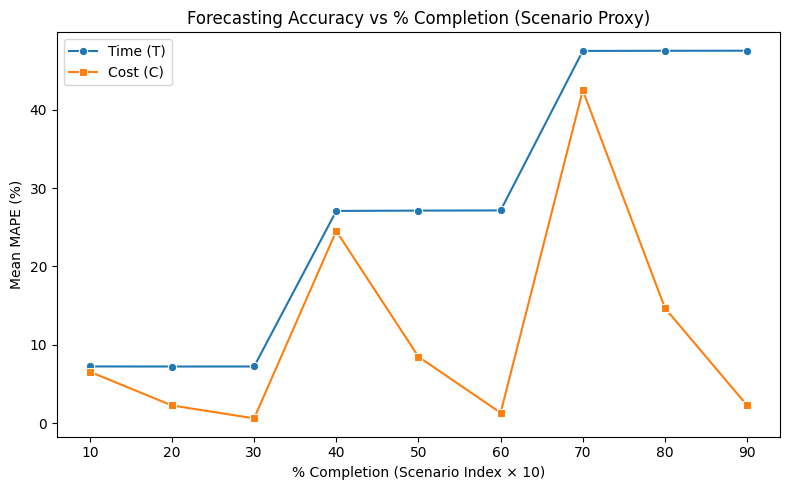

In [240]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

model_path = "/content/drive/MyDrive/DS340W Paper3 Implementation/data/RG30_ModelTable.csv"
df_model = pd.read_csv(model_path)
print(f"Loaded modeling dataset: {df_model.shape}")
display(df_model.head())

# Diagnostic spread check
print("=== Scenario-wise mean and std of T and C ===")
print(df_model.groupby("scenario")[["T_mean","C_mean"]].agg(["mean","std"]).round(4))

# --- Rename columns for clarity ---
rename_map = {
    "I2_SP": "SP", "I3_AD": "AD", "I4_LA": "LA",
    "I5_LLA": "LLA", "I6_TF": "TF",
    "TS_mean": "TSm", "CS_mean": "CSsd",
    "T_mean": "T", "C_mean": "C"
}
df_paper = df_model.rename(columns=rename_map).copy()

# --- Compute MAPE relative to baseline (no scenario normalization) ---
df_paper["MAPE_T"] = abs(df_paper["T"] - 1) * 100
df_paper["MAPE_C"] = abs(df_paper["C"] - 1) * 100

# --- Summaries ---
summary_table = pd.DataFrame({
    "Metric": ["MAPE_T","MAPE_C"],
    "25th %": [df_paper["MAPE_T"].quantile(0.25), df_paper["MAPE_C"].quantile(0.25)],
    "50th %": [df_paper["MAPE_T"].quantile(0.50), df_paper["MAPE_C"].quantile(0.50)],
    "75th %": [df_paper["MAPE_T"].quantile(0.75), df_paper["MAPE_C"].quantile(0.75)],
    "Mean":   [df_paper["MAPE_T"].mean(), df_paper["MAPE_C"].mean()]
}).round(2)

print("\n=== Forecast Accuracy Summary (Percentiles & Mean) ===")
display(summary_table)

# --- Boxplots (≈ Figs 8 & 10) ---
plt.figure(figsize=(7,4))
sns.boxplot(x="scenario", y="MAPE_T", data=df_paper, color="lightgray", width=0.6)
plt.title("Time Forecasting Accuracy (MAPE) by Scenario")
plt.ylabel("|T − 1| × 100")
plt.xlabel("Scenario (1 – 9)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
sns.boxplot(x="scenario", y="MAPE_C", data=df_paper, color="lightgray", width=0.6)
plt.title("Cost Forecasting Accuracy (MAPE) by Scenario")
plt.ylabel("|C − 1| × 100")
plt.xlabel("Scenario (1 – 9)")
plt.tight_layout()
plt.show()

# --- Line plot (≈ Figs 9 & 11) ---
df_paper["completion_%"] = df_paper["scenario"] * 10
mape_summary = df_paper.groupby("completion_%")[["MAPE_T","MAPE_C"]].mean().reset_index()

plt.figure(figsize=(8,5))
sns.lineplot(x="completion_%", y="MAPE_T", data=mape_summary, marker="o", label="Time (T)")
sns.lineplot(x="completion_%", y="MAPE_C", data=mape_summary, marker="s", label="Cost (C)")
plt.title("Forecasting Accuracy vs % Completion (Scenario Proxy)")
plt.ylabel("Mean MAPE (%)")
plt.xlabel("% Completion (Scenario Index × 10)")
plt.legend()
plt.tight_layout()
plt.show()
